# Testing the CalibratedLanedector

## Setting up Colab

In [ ]:
colab_nb = 'google.colab' in str(get_ipython())

In [ ]:
if colab_nb:
  from google.colab import drive
  drive.mount('/content/drive')

In [ ]:
if colab_nb:
  %cd /content/drive/My Drive/aad/code/tests/camera_calibration

## Exercise

In [25]:
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

Solve the TODO items in `exercises/camera_calibration/calibrated_lane_detector.py` which are labeled as **"TODO"**!

If you set the following boolean to `True`, your code will run. I would recommend to set them to `False` first and execute **all** remaining cells of this notebook. Study the outputs to know how a correct solution performs. Then switch to `run_student_code = False` and check your solution for correctness!

In [4]:
run_student_code = False

In [5]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(str(Path('../../')))

In [6]:
if run_student_code:
    from exercises.camera_calibration.calibrated_lane_detector import CalibratedLaneDetector, get_intersection, get_py_from_vp
else:
    from solutions.camera_calibration.calibrated_lane_detector import CalibratedLaneDetector, get_intersection, get_py_from_vp

TODO: Change the code in the next cell, to create an instance of *your* LaneDetector

In [7]:
def create_new_calibrated_lane_detector():
    if run_student_code:
        # TODO: Replace next line with your code here
        cld = None
    else:
        # this is how the setup code looks like for the CalibratedLaneDetector from the `solutions` directory
        model_path = Path("../../solutions/lane_detection/fastai_model.pth")
        cld = CalibratedLaneDetector(model_path=model_path)
    return cld

In [8]:
cld = create_new_calibrated_lane_detector()

## Tests on an image

We will load an image for which the yaw angle was set to 2 degrees and the pitch angle was set to to -3 degrees in the Carla simulator.

(512, 1024, 3)

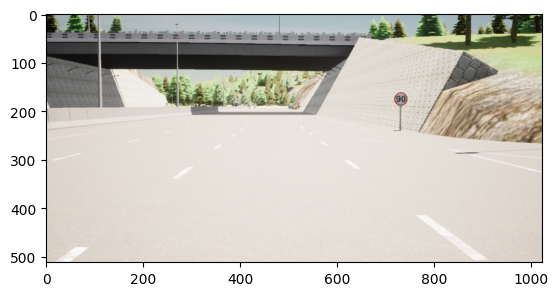

In [9]:
image_fn = str(Path("../../../data/Image_yaw_2_pitch_-3.png"))
image = cv2.imread(image_fn)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
image.shape

First we detect the left and right boundaries as usual

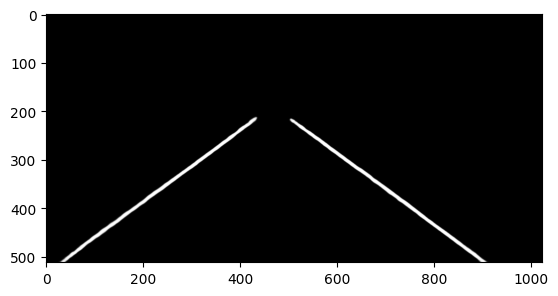

In [10]:
_, left_probs, right_probs = cld.detect(image)
# just to visualize both detections (left and right) in one image we add them up
plt.imshow(left_probs + right_probs, cmap="gray")

Next we fit straight lines to the left and right boundary

In [11]:
line_left  = cld._fit_line_v_of_u(left_probs)
line_right = cld._fit_line_v_of_u(right_probs)

Let us visualize those straight lines

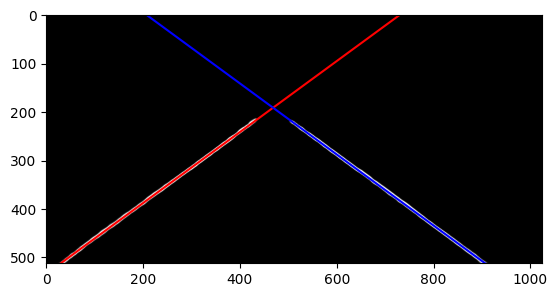

In [12]:
def plot_detected_lines(line_left, line_right):
    u = np.arange(0,cld.cg.image_width, 1)
    v_left = line_left(u)
    v_right = line_right(u)

    plt.plot(u,v_left, color='r')
    plt.plot(u,v_right, color='b')
    plt.xlim(0,cld.cg.image_width)
    plt.ylim(cld.cg.image_height,0)

plt.imshow(left_probs + right_probs, cmap="gray")
plot_detected_lines(line_left, line_right)

Now compute the vanishing point (If your code works, you should get something close to (469, 191))

In [13]:
vanishing_point = get_intersection(line_left, line_right)
print(vanishing_point)

(468.5801874879119, 190.88819196372583)


Visualize the vanishing point

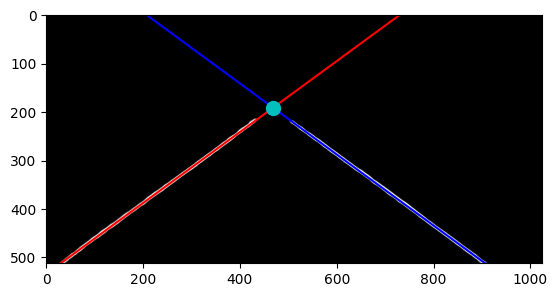

In [14]:
u_i, v_i = vanishing_point
plt.scatter([u_i],[v_i], marker="o", s=100, color="c", zorder=10)
plt.imshow(left_probs + right_probs, cmap="gray")
plot_detected_lines(line_left, line_right)

Finally determine pitch and yaw

In [15]:
pitch, yaw = get_py_from_vp(u_i, v_i, cld.cg.intrinsic_matrix)
# print values and compare to the expected result
print("pitch (deg):\n  Computed:   {:.2f}\n  True value: {:.2f}".format(np.rad2deg(pitch), -3.00))
print("yaw (deg):\n  Computed:   {:.2f}\n  True value: {:.2f}".format(np.rad2deg(yaw), 2.00))
print("")

pitch (deg):
  Computed:   -3.01
  True value: -3.00
yaw (deg):
  Computed:   2.01
  True value: 2.00



## Test on a video

Next we test the `CalibratedLaneDetector` on a video, where we have `yaw_deg=-1.7` and `pitch_deg=-2.3`. First let us have a look at the video. If the next cell does render a video on your machine, then please open the video using your file explorer to have a look (its' inside the `data` folder, which is a sibling folder of the `code` folder).

In [16]:
from IPython.display import Video
video_filename = Path("../../../data/calibration_video.mp4")
Video(video_filename)

Next the CalibratedLaneDetector is run on each image within this video. Your CalibratedLaneDetector should have some logic to **not** use the images where the vehicle is driving the turn.


The execution of the next cell will probably take some time. Be patient ;)

In [22]:
cld = create_new_calibrated_lane_detector()
yaw_list, pitch_list = [], []

vid = imageio.get_reader(video_filename,  'ffmpeg')
for image in vid:
    cld(image)
    yaw_list.append(cld.estimated_yaw_deg)
    pitch_list.append(cld.estimated_pitch_deg)

yaw, pitch =  -1.5195174791126436 -2.23984573059757
yaw, pitch =  -1.8436499413450713 -2.237078482330958
yaw, pitch =  -1.6720956997959573 -2.2561511835603523
yaw, pitch =  -1.6581705235987123 -2.242197247292036
yaw, pitch =  -1.6827136587414868 -2.295019159359868
yaw, pitch =  -1.7271620034878752 -2.310212702052329
yaw, pitch =  -1.675762943348212 -2.300846827369268
yaw, pitch =  -2.0669029754736274 -2.2880800394241705
yaw, pitch =  -1.444494363660974 -2.2959725419377217
yaw, pitch =  -1.6282791409887072 -2.2959585401913136


We can check the correctness of the lane detector with the following plots. After some initialization time steps, the `CalibratedLaneDetector` should estimate `yaw` and `pitch` with an error of less than 0.5 degrees

In [29]:
plt.plot(yaw_list, color="r", label="Estimated yaw")
plt.plot([-1.7]*len(yaw_list), color="k", ls="--", label="True yaw")
plt.legend()

AttributeError: module 'PIL' has no attribute 'Image'

<Figure size 640x480 with 1 Axes>

In [26]:
plt.plot(pitch_list, color="b", label="Estimated pitch")
plt.plot([-2.3]*len(pitch_list), color="k", ls="--", label="True pitch")
plt.legend()

AttributeError: module 'PIL' has no attribute 'Image'

<Figure size 640x480 with 1 Axes>

In [30]:
yaw_list

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195174791126436,
 -1.5195